In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1",url,untar=True,cache_dir='.',cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:
os.listdir(dataset_dir)

['train', 'imdb.vocab', 'imdbEr.txt', 'README', 'test']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg',
 'urls_unsup.txt',
 'unsupBow.feat',
 'unsup',
 'labeledBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'pos']

In [5]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [6]:
os.listdir(train_dir)

['neg',
 'urls_unsup.txt',
 'unsupBow.feat',
 'labeledBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'pos']

In [7]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(5):
    print("Recenzja:", text_batch.numpy()[i])
    print("Etykieta:", label_batch.numpy()[i])

Recenzja: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Etykieta: 0
Recenzja: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [10]:
print(f"etykieta 0: {raw_train_ds.class_names[0]}")
print(f"etykieta 1: {raw_train_ds.class_names[1]}")

etykieta 0: neg
etykieta 1: pos


In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [14]:
#standardyzacja danych tekstowych
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [15]:
#wektoryzacja tekstu
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [16]:
#adaptacja warstwy wektoryzacji do tesktu(bez etykiety)
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [17]:
text_batch, labels_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], labels_batch[0]
print("Recenzja:", first_review)
print("Etykieta:", raw_train_ds.class_names[first_label])
print("Recenzja zwektoryzowana!:", vectorize_layer(first_review))

Recenzja: tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br 

In [20]:
print(f"147 ==> {vectorize_layer.get_vocabulary()[147]}")
print(f"1376 ==> {vectorize_layer.get_vocabulary()[1376]}")
print(f"5 ==> {vectorize_layer.get_vocabulary()[5]}")
print(f"313 ==> {vectorize_layer.get_vocabulary()[313]}")
print(f"7080 ==> {vectorize_layer.get_vocabulary()[7080]}")
print(f"rozmiar slownika: {len(vectorize_layer.get_vocabulary())}")

147 ==> though
1376 ==> mysterious
5 ==> of
313 ==> night
7080 ==> lurking
rozmiar slownika: 10000


In [21]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [22]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
#tworzenie modelu
embedding_dim = 16
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - binary_accuracy: 0.5061 - loss: 0.6819 - val_binary_accuracy: 0.5756 - val_loss: 0.6179
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - binary_accuracy: 0.6181 - loss: 0.5861 - val_binary_accuracy: 0.7024 - val_loss: 0.5054
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - binary_accuracy: 0.7587 - loss: 0.4736 - val_binary_accuracy: 0.7684 - val_loss: 0.4314
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - binary_accuracy: 0.8190 - loss: 0.3990 - val_binary_accuracy: 0.7904 - val_loss: 0.3911
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - binary_accuracy: 0.8519 - loss: 0.3508 - val_binary_accuracy: 0.8098 - val_loss: 0.3625
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8685 - loss: 0.3180 - val_binary_accuracy: 0.8182 - val_loss: 0.3462
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8794 - loss: 0.2929 - val_binary_accuracy: 0.8316 - val_loss: 0.3307
Epoch

In [32]:
loss,accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - binary_accuracy: 0.8292 - loss: 0.3316
Loss:  0.33088260889053345
Accuracy:  0.8317199945449829


In [33]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

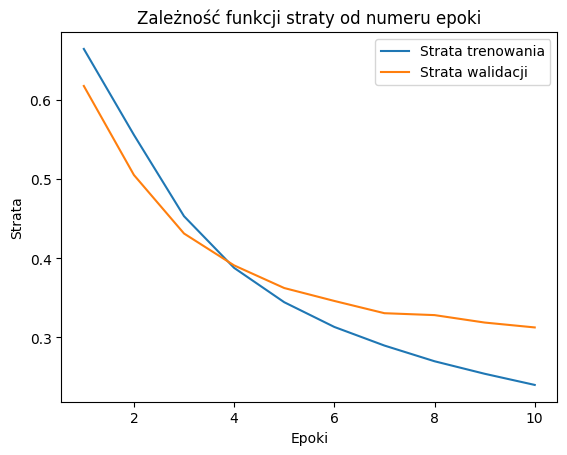

In [34]:
# prompt: narysuj wykres zależności numeru epoki od funkcji straty - loss

import matplotlib.pyplot as plt
plt.plot(range(1, epochs+1), history_dict['loss'], label='Strata trenowania')
plt.plot(range(1, epochs+1), history_dict['val_loss'], label='Strata walidacji')
plt.title('Zależność funkcji straty od numeru epoki')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()


In [36]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)
wynik = export_model.evaluate(raw_test_ds)
print(wynik)

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8564 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
[0.0, 0.0, 0.0, 0.8572400212287903]
